## Image preparation

Remove duplicates from input directory by evaluating the image hash

* Note 1: It can also be used to resize images to a defined size (e.g. 32x32 pixels) from an input directory (Input_Dir) into an output directory (Resize_Dir).
* Note 2: It's not mandatory to resize with this notebook, because it will be performed in the training notebooks (`02_Train-CNN_...`)

### Basic Parameter

IMPORTANT: Do not rename any variables in this section, they are externally referenced in the GitHub action `Train Model`.

* `Input_Dir`: Path to the input directory containing unscaled training images
* `Resize_Dir`: Path to the output directory where resized and scaled images will be saved.
* `Save_Resized_Images`: Set to true to save resized images (Optional: Images will be resized in training notebook automatically)
* `Input_Shape`: Image dimensions (width, height, channels)
* `Phash_Threshold`: Threshold for image similarity check by perceptual image hash (0: identical, >= 5: visually very similar, even higher: more different)

In [1]:
# Parameters
Input_Dir = 'data_raw_all'
Resize_Dir = 'data_resize_all'

# Save resized images
Save_Resized_Images = False

# Input image size [width, height, channels]
Input_Shape = (32, 32, 3)

# Threshold for image similarity check by perceptual image hash
Phash_Threshold = 2


In [2]:
# Parameters
Input_Dir = "data_raw_all"
Output_Dir = "data_resize_all"


### Load Libraries

In [3]:
import os
import sys
import glob
import shutil
from pathlib import Path
import hashlib
from collections import defaultdict
from PIL import Image
import imagehash
import matplotlib.pyplot as plt

# Prepare folders
if not (Path(Input_Dir).exists() and Path(Input_Dir).is_dir()): # Check if input is availabe
    sys.exit(f"Folder '{Input_Dir}' does not exist.")

# Prepare duplicates folder (as subfolder of input folder)
Duplicates_Dir = os.path.join(Input_Dir, "duplicates")
Path(Duplicates_Dir).mkdir(parents=True, exist_ok=True)  # Create duplicates folder if it doesn't exist

if Save_Resized_Images:
    import tensorflow as tf
    Path(Resize_Dir).mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn't exist


### Delete Output Directory (Resized Images)

In [4]:
if os.path.exists(Resize_Dir):
    files = glob.glob(Resize_Dir + '/*.jpg')

    # Delete files
    for f in files:
        os.remove(f)

    print(str(len(files)) + " files have been deleted.")
else:
    print(f"No files have been deleted")


0 files have been deleted.


### ### Load Files, detect and move duplicates by hash + (optional: Resize Images)

In [5]:
files = glob.glob(Input_Dir + '/*.jpg')

hashesSha256 = {}
hashesPhash = {}

# Process files
for i, file in enumerate(files):
    try:
        img = Image.open(file).convert("RGB")

        # Exact hash (SHA256 of JPEG bytes)
        with open(file, "rb") as f:
            bytesData = f.read()
        hashVal = hashlib.sha256(bytesData).hexdigest()

        if hashVal in hashesSha256:
            dupTarget = os.path.join(Duplicates_Dir, os.path.basename(file))
            shutil.move(file, dupTarget)
            print(f"Exact duplicate moved: {file} -> {dupTarget}")
            continue
        else:
            hashesSha256[hashVal] = [file]

        # Perceptual hash
        phashVal = imagehash.phash(img)

        foundSimilar = False
        for existingPhash in hashesPhash:
            if abs(phashVal - existingPhash) <= Phash_Threshold:
                dupTarget = os.path.join(Duplicates_Dir, os.path.basename(file))
                shutil.move(file, dupTarget)
                print(f"Near-duplicate moved: {file} -> {dupTarget}")
                foundSimilar = True
                break

        if not foundSimilar:
            hashesPhash[phashVal] = [file]

            # Resize images (e.g. for debug purposes)
            if Save_Resized_Images:
                # Read with TF
                imageBytes = tf.io.read_file(file)
                imageTf = tf.image.decode_image(imageBytes, channels=Input_Shape[2], expand_animations=False)
                
                # Resize if shape differs
                # IMPORTANT: Use MITCHELLCUBIC filter to match ESP32 resize algorithm
                if imageTf.shape[0] != Input_Shape[0] or imageTf.shape[1] != Input_Shape[1]:
                    imageTf = tf.image.resize(imageTf, [Input_Shape[0], Input_Shape[1]], method=tf.image.ResizeMethod.MITCHELLCUBIC)
                    imageTf = tf.clip_by_value(tf.cast(imageTf, tf.uint8), 0, 255)
                else:
                    imageTf = tf.cast(imageTf, tf.uint8)
                
                # Save resized
                savePath = os.path.join(Resize_Dir, os.path.basename(file))
                tf.io.write_file(savePath, tf.io.encode_jpeg(imageTf, quality=100))

    except Exception as e:
        print(f"Error processing {file}: {e}")

    if i % 500 == 0:
        print(f"{i} files processed...")

print(f"Completed. {i+1} files processed")


0 files processed...


500 files processed...


1000 files processed...


1500 files processed...


Completed. 1838 files processed


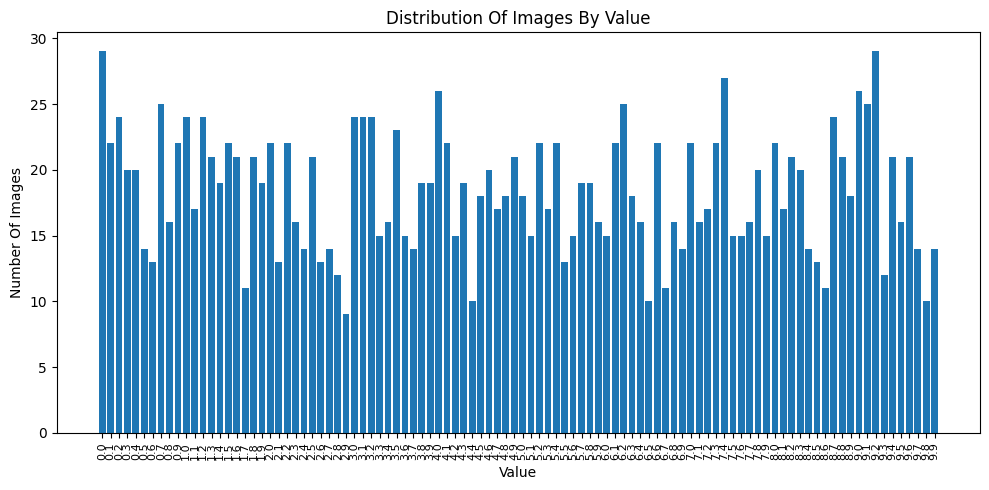

In [6]:
# Distribution by filename prefix (category)
remainingFiles = glob.glob(os.path.join(Input_Dir, "*.jpg"))
distribution = defaultdict(int)

 # Extract real value from filename
for file in remainingFiles:
    base = Path(file).name
    realValue = base[:3]
    distribution[realValue] += 1

# Plot distribution ----
realValues = sorted(distribution.keys(), key=lambda x: float(x))
counts = [distribution[v] for v in realValues]

plt.figure(figsize=(10,5))
plt.bar(realValues, counts)
plt.xlabel("Value")
plt.ylabel("Number Of Images")
plt.title("Distribution Of Images By Value")
plt.xticks(ticks=range(len(realValues)), labels=realValues, rotation=90, fontsize=8)
plt.tight_layout()
plt.show()
